# Automated Anomaly Detection
**Objective**: Understand and practice automated anomaly detection using various techniques.

**Task**: Autoencoders for Anomaly Detection

**Steps**:
1. Data Set: Download a dataset of electricity consumption data.
2. Build an Autoencoder: Construct a simple autoencoder using a neural network for the
normal consumption data.
3. Identify Anomalies: Use the trained model to reconstruct the data and identify anomalies based on reconstruction error.
4. Visualize: Plot both the actual and reconstructed data to highlight anomalies.

2025-05-24 13:44:23.113936: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 13:44:23.117258: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 13:44:23.126195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748094263.141749   14813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748094263.146279   14813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748094263.160345   14813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Sample of the generated electricity consumption data:
                     consumption
timestamp                       
2023-01-01 00:00:00   102.483571
2023-01-01 01:00:00    63.207469
2023-01-01 02:00:00   113.988058
2023-01-01 03:00:00   122.880402
2023-01-01 04:00:00   117.644793
Total data points: 4320
Shape of training sequences: (3436, 24, 1)
Shape of testing sequences: (860, 24, 1)
Shape of flattened training sequences: (3436, 24)
Shape of flattened testing sequences: (860, 24)

Autoencoder Model Summary:


2025-05-24 13:44:24.788371: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 774 (3.02 KB)

 Trainable params: 774 (3.02 KB)

 Non-trainable params: 0 (0.00 B)


Training the Autoencoder...
Training complete.


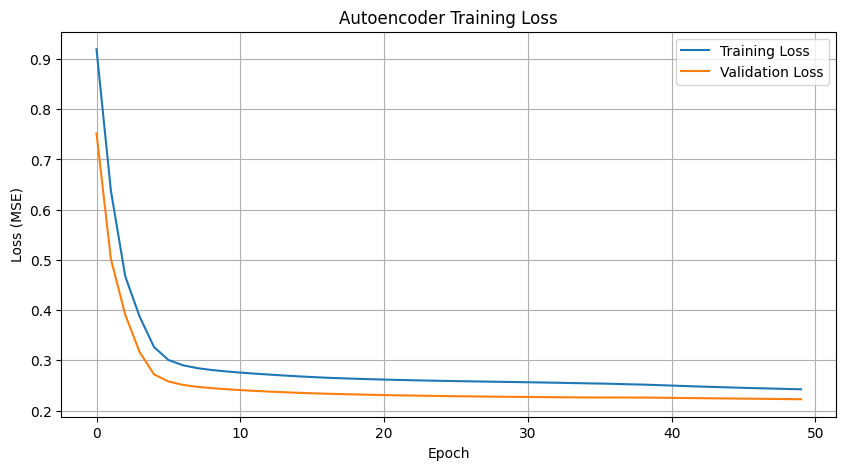

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step

Mean training reconstruction error: 0.2398
Standard deviation of training reconstruction error: 0.4661
Anomaly threshold (Mean + 2*Std): 1.1720

Number of anomalies detected in test set: 63
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step


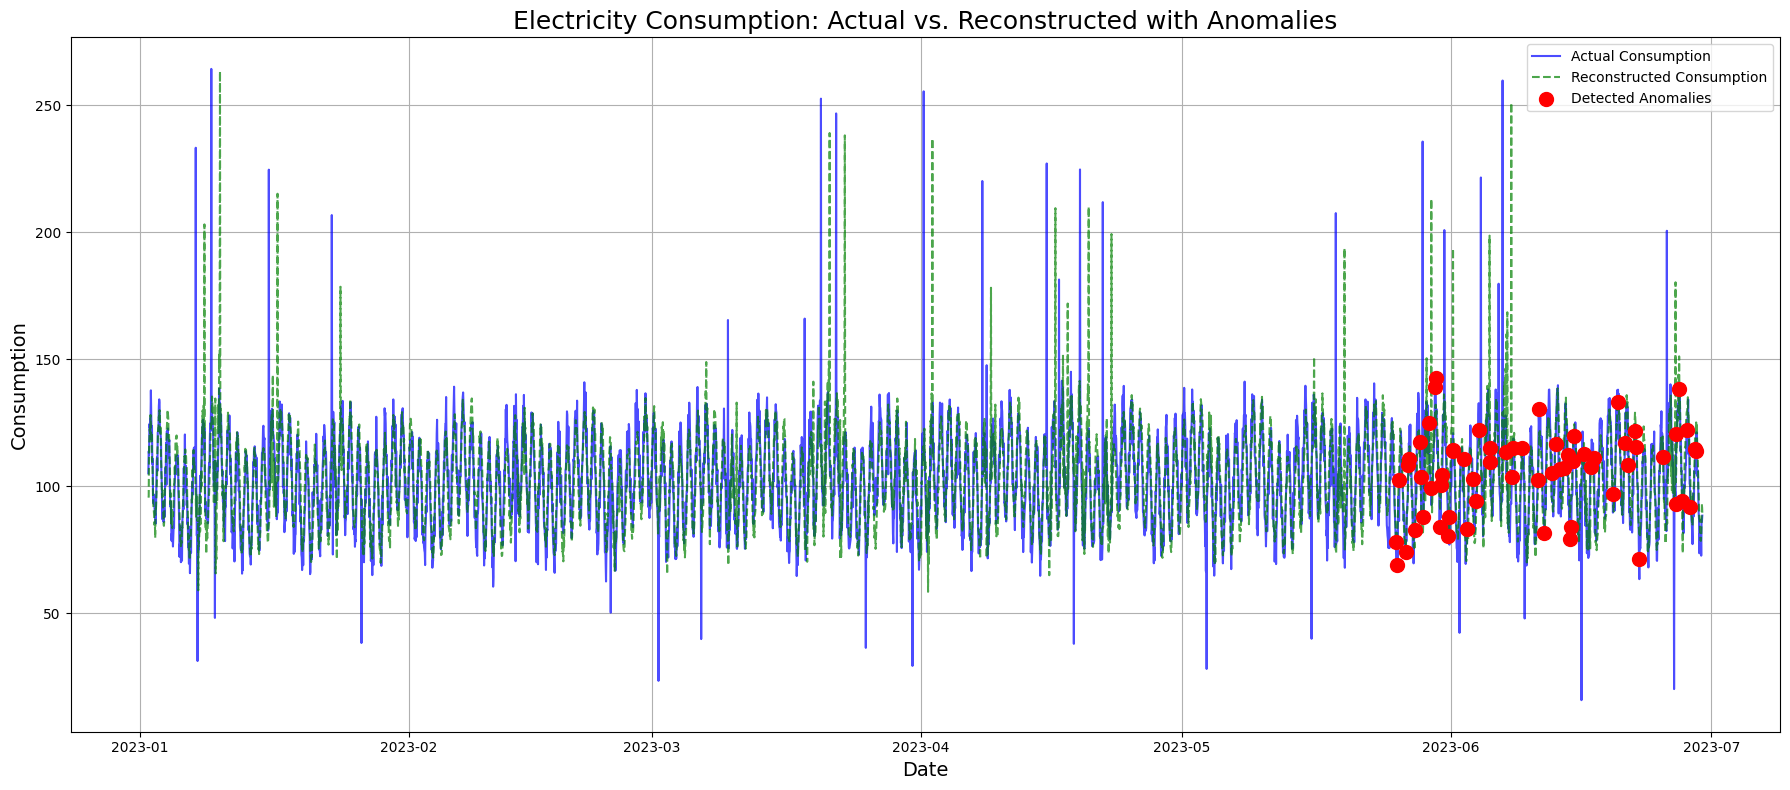

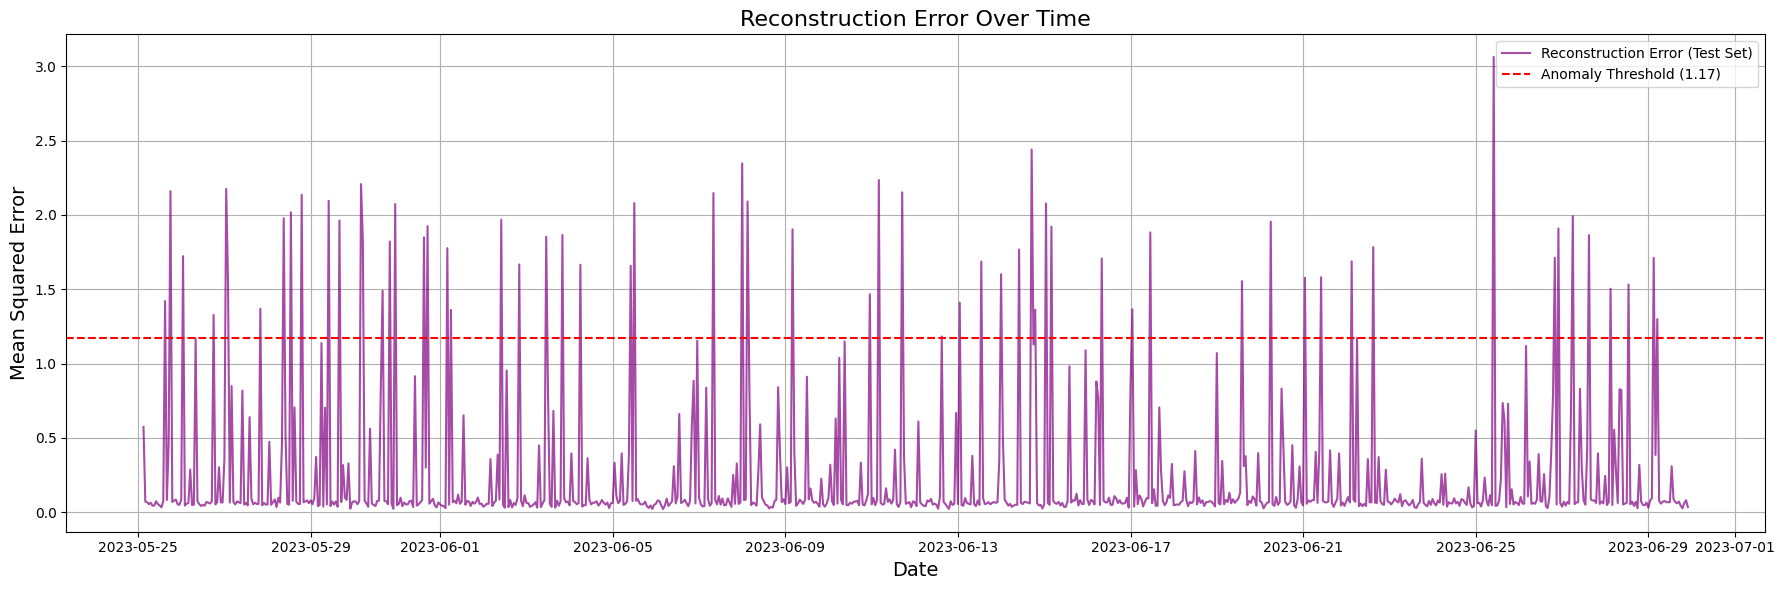

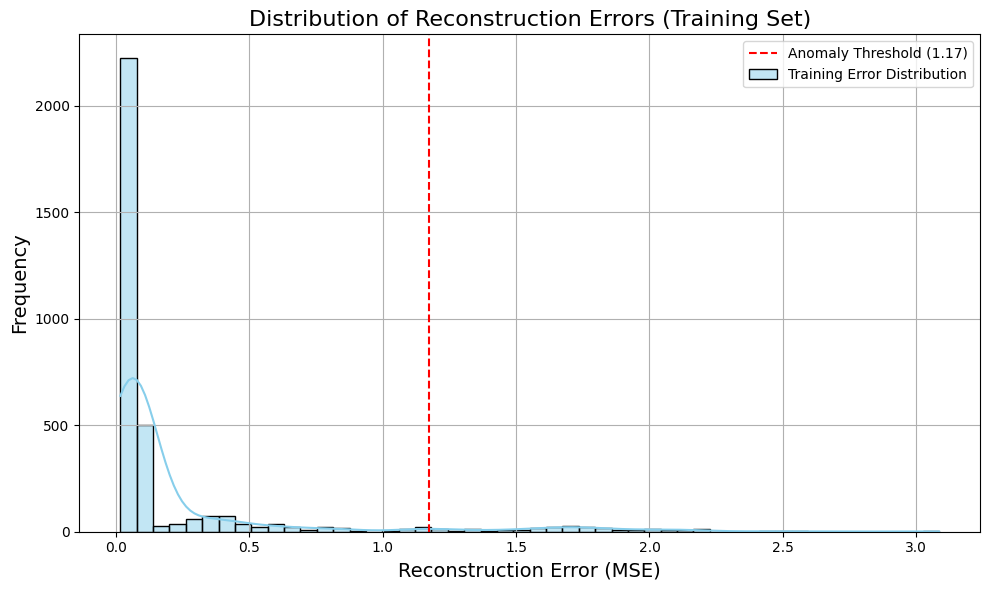

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
def generate_electricity_data(num_days=365,points_per_day=24,anomaly_ratio=0.02):
    total_points=num_days*points_per_day
    time=np.arange(total_points)
    base_consumption=(
        100+
        20*np.sin(time/points_per_day*2*np.pi)+
        10*np.sin(time/(points_per_day*7)*2*np.pi)+
        0.05*(time/total_points)*100
    )
    noise=np.random.normal(0,5,total_points)
    consumption=base_consumption+noise
    num_anomalies=int(total_points*anomaly_ratio)
    anomaly_indices=np.random.choice(total_points,num_anomalies,replace=False)
    for idx in anomaly_indices:
        if np.random.rand()>0.5:
            consumption[idx]+=np.random.uniform(50,150)
        else:
            consumption[idx]-=np.random.uniform(30,80)
            if consumption[idx]<0:
                consumption[idx]=np.random.uniform(5,10)
    df=pd.DataFrame({'timestamp':pd.to_datetime(pd.date_range(start='2023-01-01',periods=total_points,freq='H')),
                       'consumption':consumption})
    df=df.set_index('timestamp')
    return df
electricity_df=generate_electricity_data(num_days=180,points_per_day=24,anomaly_ratio=0.01)
print("Sample of the generated electricity consumption data:")
print(electricity_df.head())
print(f"Total data points: {len(electricity_df)}")
scaler=StandardScaler()
scaled_data=scaler.fit_transform(electricity_df[['consumption']])
TIME_STEPS=24
def create_sequences(data,time_steps):
    xs=[]
    for i in range(len(data)-time_steps):
        xs.append(data[i:(i+time_steps)])
    return np.array(xs)
X=create_sequences(scaled_data,TIME_STEPS)
X_train,X_test=train_test_split(X,test_size=0.2,random_state=42)
print(f"Shape of training sequences: {X_train.shape}")
print(f"Shape of testing sequences: {X_test.shape}")
X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_flat=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print(f"Shape of flattened training sequences: {X_train_flat.shape}")
print(f"Shape of flattened testing sequences: {X_test_flat.shape}")
input_dim=X_train_flat.shape[1]
latent_dim=int(input_dim/4)
input_layer=Input(shape=(input_dim,))
encoder=Dense(latent_dim*2,activation='relu')(input_layer)
encoder=Dense(latent_dim,activation='relu')(encoder)
decoder=Dense(latent_dim*2,activation='relu')(encoder)
decoder=Dense(input_dim,activation='linear')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001),loss='mse')
print("\nAutoencoder Model Summary:")
autoencoder.summary()
print("\nTraining the Autoencoder...")
history=autoencoder.fit(
    X_train_flat,X_train_flat,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=0
)
print("Training complete.")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()
X_pred_flat=autoencoder.predict(X_test_flat)
mse_errors=np.mean(np.power(X_test_flat-X_pred_flat,2),axis=1)
X_train_pred_flat=autoencoder.predict(X_train_flat)
train_mse_errors=np.mean(np.power(X_train_flat-X_train_pred_flat,2),axis=1)
threshold=np.mean(train_mse_errors)+2*np.std(train_mse_errors)
print(f"\nMean training reconstruction error: {np.mean(train_mse_errors):.4f}")
print(f"Standard deviation of training reconstruction error: {np.std(train_mse_errors):.4f}")
print(f"Anomaly threshold (Mean + 2*Std): {threshold:.4f}")
anomalies_indices=np.where(mse_errors>threshold)[0]
original_test_start_index=(len(electricity_df)-len(X_test))-TIME_STEPS+1 
anomaly_timestamps=[]
anomaly_values=[]
for idx in anomalies_indices:
    original_data_index=original_test_start_index+idx+TIME_STEPS-1
    if original_data_index < len(electricity_df): 
        anomaly_timestamps.append(electricity_df.index[original_data_index])
        anomaly_values.append(electricity_df['consumption'].iloc[original_data_index])
print(f"\nNumber of anomalies detected in test set: {len(anomalies_indices)}")
X_full_flat=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X_full_pred_flat=autoencoder.predict(X_full_flat)
X_full_pred=X_full_pred_flat.reshape(X_full_pred_flat.shape[0],TIME_STEPS,1)
reconstructed_consumption_scaled=X_full_pred[:,0,0]
reconstructed_consumption=scaler.inverse_transform(reconstructed_consumption_scaled.reshape(-1,1))
actual_consumption_for_plot=electricity_df['consumption'].iloc[TIME_STEPS:].values
reconstructed_consumption_for_plot=reconstructed_consumption.flatten()
plot_timestamps=electricity_df.index[TIME_STEPS:]
plt.figure(figsize=(18,8))
plt.plot(plot_timestamps,actual_consumption_for_plot,label='Actual Consumption',color='blue',alpha=0.7)
plt.plot(plot_timestamps,reconstructed_consumption_for_plot,label='Reconstructed Consumption',color='green',linestyle='--',alpha=0.7)
if anomaly_timestamps:
    plt.scatter(anomaly_timestamps,anomaly_values,color='red',s=100,label='Detected Anomalies',zorder=5,marker='o')
plt.title('Electricity Consumption: Actual vs. Reconstructed with Anomalies',fontsize=18)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Consumption',fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Corrected plotting for reconstruction error:
test_indices = np.array(range(len(scaled_data) - TIME_STEPS))[len(X_train):]
test_plot_timestamps = electricity_df.index[test_indices + TIME_STEPS - 1] # End of the sequence
plt.figure(figsize=(18,6))
plt.plot(test_plot_timestamps,mse_errors,label='Reconstruction Error (Test Set)',color='purple',alpha=0.7)
plt.axhline(y=threshold,color='red',linestyle='--',label=f'Anomaly Threshold ({threshold:.2f})')
plt.title('Reconstruction Error Over Time',fontsize=16)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Mean Squared Error',fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
sns.histplot(train_mse_errors,bins=50,kde=True,color='skyblue',label='Training Error Distribution')
plt.axvline(x=threshold,color='red',linestyle='--',label=f'Anomaly Threshold ({threshold:.2f})')
plt.title('Distribution of Reconstruction Errors (Training Set)',fontsize=16)
plt.xlabel('Reconstruction Error (MSE)',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()